In [2]:
import os
import pandas as pd
import numpy as np
import re
import ast
import json
DATA_DIR = '../../data/Evaluation_CoTs/'
storage_dir = os.path.join(DATA_DIR, 'Algo_Design_Data')
file_store_path = os.path.join(storage_dir, 'final_extracted.json')
import sys
sys.path.insert(0, '../')
from utils import *

# to do: if we will use supervised learning model, need to run other experiments like other Supervised learning model

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from CS_based_early_stopping import trained_LR_model, CS_early_stopping,trained_RF_model,trained_NB_model
import itertools
from itertools import combinations


feature_li = ['LEN','QUA_IM','DIF_IV','SIM_INPUT','SIM_COT_BIGRAM','SIM_COT_AGG','SIM_AC_BIGRAM','SIM_AC_PW']

df = pd.read_json(file_store_path, lines=True)
df = df[df.Model != 'gpt-4'].reset_index(drop=True)

In [23]:
df['SC_correctness'].mean()

0.43395805443998214

In [4]:
# df = pd.read_json(os.path.join(storage_dir, 'final_extracted_ES.json'), lines=True)
# df = df[df.Model != 'gpt-4'].reset_index(drop=True)

# Abalation Study 2: Compare effects of different IDV score models

In [12]:
df['direct_acc'] = df['Correctness'].apply(lambda x: x[0])

# Calculate the mean of 'direct_acc' and assign it to a new variable 'direct_acc_mean'
direct_acc_mean = df['direct_acc'].mean()

def abs_metric1(acc, cost, sc_acc, sc_cost=40, direct_acc=direct_acc_mean, direct_cost=1):
    if direct_acc is None:
        direct_acc = sc_acc

    # Normalize the accuracy to be between 0 and 1
    if acc >= sc_acc:
        acc_factor = 1
    elif acc <= direct_acc:
        acc_factor = 0
    else:
        acc_factor = (acc - direct_acc) / (sc_acc - direct_acc)

    # Normalize the cost to be between 0 and 1
    if cost <= direct_cost:
        cost_factor = 1
    elif cost >= sc_cost:
        cost_factor = 0
    else:
        cost_factor = (sc_cost - cost) / (sc_cost - direct_cost)

    # Calculate the weighted average of acc_factor and cost_factor
    metric = 0.5 * acc_factor + 0.5 * cost_factor

    return metric

### LR

In [5]:
feature_li = ['LEN','QUA_IM','DIF_IV','SIM_INPUT','SIM_COT_BIGRAM','SIM_COT_AGG','SIM_AC_BIGRAM','SIM_AC_PW']
df_cs_lr,auroc = trained_LR_model(df, feature_li, report_auroc=True)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64
         Current function value: 0.506344
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   2

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AUROC score is: 0.8065504990489534
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.46022304832713756
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.8728624535315985
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

In [15]:
def find_best_parameters(df, abs_metric_func, N_range=(3, 10), threshold_range=(0.1, 0.5), step=0.1):
    best_metric = float('-inf')
    best_threshold = None
    best_N = None
    best_df_final = None
    best_acc = None
    best_cost = None

    for N in range(N_range[0], N_range[1] + 1):
        for threshold in np.arange(threshold_range[0], threshold_range[1] + step, step):
            df_final = CS_early_stopping(df=df, threshold=threshold, N=N)
            acc = df_final['CS_correctness'].mean()
            cost = df_final['CS_steps'].mean()
            sc_acc = df_final['SC_correctness'].mean()
            metric = abs_metric_func(acc, cost, sc_acc)

            if metric > best_metric:
                best_metric = metric
                best_threshold = threshold
                best_N = N
                best_df_final = df_final
                best_acc = acc
                best_cost = cost

    print(f"Best parameters: N={best_N}, threshold={best_threshold}, metric={best_metric}, accuracy={best_acc}, cost={best_cost}")
    return best_df_final

df_final_best = find_best_parameters(df_cs_lr, abs_metric1)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.46022304832713756
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.8728624535315985
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45539033457249073
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 7.671375464684015
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4591078066914498
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 11.433457249070631
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.46431226765799255
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 13.874349442379183
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
C

### Random Model

In [16]:
import numpy as np

# Assuming your DataFrame is called 'df'
# and the column containing the list of floats is called 'confidence_score'

# Create a new column 'random_score' with random values between 0 and 1
df_cs_lr['confidence_score'] = df_cs_lr['confidence_score'].apply(lambda x: [np.random.uniform(0, 1) for _ in x])

In [17]:
df_random_best = find_best_parameters(df_cs_lr, abs_metric1)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.40148698884758366
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 3.3278810408921933
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.39776951672862454
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 3.7479553903345724
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.3996282527881041
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.265799256505576
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.40929368029739777
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.987360594795539
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS

### RF

In [18]:
df_cs_rf, auroc = trained_RF_model(df, feature_li, report_auroc=True)
df_rf_best = find_best_parameters(df_cs_rf, abs_metric1)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be

The AUROC score is: 0.7914665794253086
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4579925650557621
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 6.377323420074349
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4591078066914498
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 7.710408921933086
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4639405204460966
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 9.743494423791821
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4620817843866171
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 12.729739776951673
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.4286245353159

### NB

In [19]:
df_cs_svm, auroc = trained_NB_model(df, feature_li, report_auroc=True)
df_final_svm = find_best_parameters(df_cs_svm, abs_metric1)

Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.8015948052024352
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45985130111524164
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.908550185873606
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45985130111524164
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.908550185873606
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45985130111524164
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.908550185873606
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.45985130111524164
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.908550185873606
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.4286245353

### BERT



In [5]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('vectara/hallucination_evaluation_model')

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [11]:
DATA_DIR = "../../data/Evaluation_CoTs/"
input_file_path = os.path.join(DATA_DIR, 'final.csv')
df_raw = pd.read_csv(input_file_path)

In [25]:
[list(df_raw.iloc[:5]['CoT_0'].values)]

[["Step 1: Calculate the total number of eggs laid by Janet's ducks per day.\n         The question states that Janet's ducks lay 16 eggs per day.\n         \n         Step 2: Calculate the number of eggs used for Janet's breakfast every day.\n         The question states that Janet eats 3 eggs for breakfast every morning.\n         \n         Step 3: Calculate the number of eggs used for baking muffins every day.\n         The question states that Janet bakes muffins for her friends every day using 4933828 eggs.\n         \n         Step 4: Calculate the number of remaining eggs that Janet can sell at the farmers' market.\n         Total eggs laid per day - Eggs used for breakfast - Eggs used for baking = Remaining eggs for sale\n         16 - 3 - 4933828 = -4933815 eggs\n         \n         Since the number of remaining eggs is negative, this means that Janet does not have any eggs left to sell at the farmers' market.\n         \n         Step 5: Calculate the amount of money Janet m

In [21]:
df_raw.iloc[:5]['CoT_0']

0    Step 1: Calculate the total number of eggs lai...
1    Step 1: The robe takes 2287720 bolts of blue f...
2    Step 1: Identify the given information.\n     ...
3    Step 1: Determine the total number of cups of ...
4    Step 1: Determine the price of each glass.\n  ...
Name: CoT_0, dtype: object

In [36]:
from sentence_transformers import CrossEncoder
from sklearn.metrics import roc_auc_score
from CS_based_early_stopping import train_test_split_stratify

def predict_confidence_score(df, df_raw, model, test_size=0.3, random_state=2024, report_auroc=False):
    # Randomly split the df dataframe into training and testing sets
    df_train, df_test = train_test_split_stratify(df, test_size=test_size, random_state=random_state)

    # Reset the index of the training and testing dataframes
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    # Retrieve the corresponding rows from df_raw based on the index of df_test
    df_raw_test = df_raw.loc[df_test.id]


    # Initialize an empty list to store the confidence scores for each row
    confidence_scores = []

    # Iterate over each row in df_raw_test
    for _, row in df_raw_test.iterrows():
        # Get the reference text
        reference = row['Question']

        # Prepare input pairs for the model (CoT_0 to CoT_39)
        pairs = [(row[f'CoT_{i}'], reference) for i in range(40)]

        # Predict confidence scores using the model
        scores = model.predict(pairs)

        # Append the scores to the confidence_scores list
        confidence_scores.append(scores)

    # Assign the confidence scores to the 'confidence_score' column in df_test
    df_test['confidence_score'] = confidence_scores

    # if report_auroc:
    #     y_test = df_test['Correctness']
    #     auroc = roc_auc_score(y_test, df_test['confidence_score'].apply(lambda x: max(x)))
    #     print(f"The AUROC score is: {auroc}")
    #     return df_test, auroc

    return df_test

In [38]:
df_final_bert = predict_confidence_score(df, df_raw, model, test_size=0.3, random_state=2024, report_auroc=True) # Run random model

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64


In [51]:
from sklearn.metrics import roc_auc_score

# Assuming you have a DataFrame called 'df' with columns 'correctness' and 'confidence_score'

# Flatten the lists of labels and probabilities
labels = [item for sublist in df_final_bert['Correctness'] for item in sublist]
probabilities = [item for sublist in df_final_bert['confidence_score'] for item in sublist]

# Calculate the AU-ROC score
au_roc = roc_auc_score(labels, probabilities)

print(f"AU-ROC score: {au_roc:.4f}")

AU-ROC score: 0.5399


In [52]:
df_bert = CS_early_stopping(df=df_final_bert, threshold=0.1, N=3)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4133828996282528
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.049814126394052
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287


In [21]:
df_final_bert = pd.read_json('BERT.json', lines=True)

In [22]:
df_best_bert = find_best_parameters(df_final_bert, abs_metric1)

SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4133828996282528
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 4.049814126394052
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.40892193308550184
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 5.607806691449814
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.4052044609665427
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 7.286617100371747
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC : 0.3992565055762082
SC_Avg_Steps : 40
ES_Avg_Steps : 15.74721189591078
CS_Avg_Steps : 9.039776951672863
ASC_Avg_Steps : 13.399256505576208
ASC_ACC : 0.42973977695167287
SC_ACC : 0.42862453531598516
ES_ACC : 0.4267657992565056
CS_ACC

# Ablation Study 3: Evaluation on test data

In [25]:
import sys
import os
import pandas as pd
sys.path.insert(0, '../')
from CS_based_early_stopping import trained_LR_model, CS_early_stopping,customized_LR_model
DATA_DIR = '../../data/Evaluation_CoTs/Algo_Design_Data/'

file_path = os.path.join(DATA_DIR, 'final_extracted.json')
file_path_asc = os.path.join(DATA_DIR, 'final_extracted_asc.json')
df_with_features_asc = pd.read_json(file_path_asc, lines=True)
file_path_ES = os.path.join(DATA_DIR, 'final_extracted_es.json')
df_with_features_ES = pd.read_json(file_path_ES, lines=True)


df_with_features = pd.read_json(file_path, lines=True)
df_with_features = df_with_features[df_with_features.Model != 'gpt-4'].reset_index(drop=True)

# df_with_features = pd.concat([df_with_features, df_with_features_2], ignore_index=True)
feature_li = ['LEN','QUA_IM','DIF_IV','SIM_INPUT','SIM_COT_BIGRAM','SIM_COT_AGG','SIM_AC_BIGRAM','SIM_AC_PW']
df_cs,coe = trained_LR_model(df_with_features, feature_li, report_auroc=False,train_mode=True)


/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Train DataFrame:
Model
llama3_cleaned             2099
claude-3-haiku-20240307    2097
gpt-3.5-turbo-0125         2078
Name: count, dtype: int64
Name
GSM8K_test               1050
GSM8K_hard               1050
BigBench_hard            1047
MathQA_challenge_test    1047
MathQA_dev               1041
BigBench_easy            1039
Name: count, dtype: int64

Test DataFrame:
Model
claude-3-haiku-20240307    900
llama3_cleaned             900
gpt-3.5-turbo-0125         890
Name: count, dtype: int64
Name
GSM8K_hard               450
BigBench_hard            450
GSM8K_test               450
MathQA_challenge_test    448
MathQA_dev               447
BigBench_easy            445
Name: count, dtype: int64
         Current function value: 0.506344
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            Correctness   No. Observations:               250960
Model:                          Logit   Df Residuals:                   2

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
coes = coe[1:]
intercept = coe[0]

In [27]:
df_raw_es, auroc = customized_LR_model(df_with_features_ES, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_es = CS_early_stopping(df=df_raw_es, threshold=0.1, N=3)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.7796037795435655
SC_ACC : 0.6921290484559377
ES_ACC : 0.6921918152146623
CS_ACC : 0.7055611348229978
SC_Avg_Steps : 40
ES_Avg_Steps : 11.689492844589505
CS_Avg_Steps : 3.892229475269897
ASC_Avg_Steps : 9.965227215666584
ASC_ACC : 0.6916896811448657


In [28]:
df_raw_asc, auroc = customized_LR_model(df_with_features_asc, feature_li, coe=coes,intercept=intercept,report_auroc=True)
df_final_asc = CS_early_stopping(df=df_raw_asc, threshold=0.1, N=3)

/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/guangya/miniconda3/envs/env1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(d

The AUROC score is: 0.8615435191853272
SC_ACC : 0.6135947861879717
ES_ACC : 0.601474959981706
CS_ACC : 0.6520695174937114
SC_Avg_Steps : 40
ES_Avg_Steps : 16.522353075691743
CS_Avg_Steps : 4.98473587925909
ASC_Avg_Steps : 14.546821404070432
ASC_ACC : 0.6103933226617883


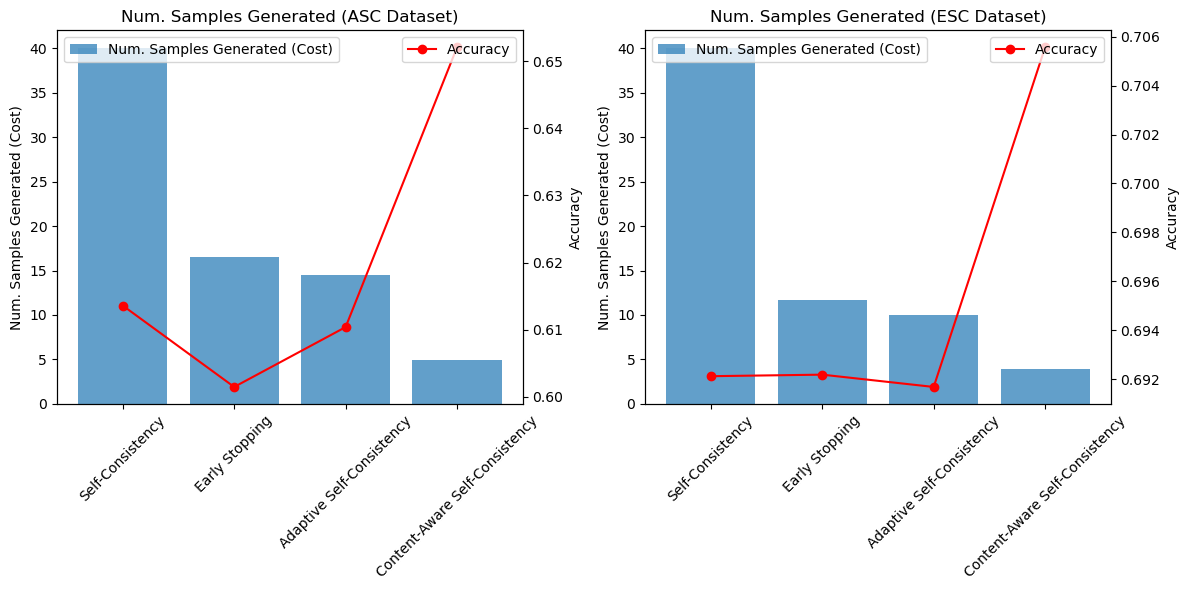

In [32]:
import matplotlib.pyplot as plt
df_final_ES = df_final_es

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for df_final_asc
methods_asc = ['Self-Consistency', 'Early Stopping', 'Adaptive Self-Consistency', 'Content-Aware Self-Consistency']
steps_asc = [40, df_final_asc['ES_steps'].mean(), df_final_asc['asc_steps'].mean(), df_final_asc['CS_steps'].mean()]
accuracies_asc = [df_final_asc['SC_correctness'].mean(), df_final_asc['ES_correctness'].mean(),
                   df_final_asc['asc_correctness'].mean(), df_final_asc['CS_correctness'].mean()]

ax1.bar(methods_asc, steps_asc, alpha=0.7, label='Num. Samples Generated (Cost)')
ax1.set_ylabel('Num. Samples Generated (Cost)')
ax1.set_title('Num. Samples Generated (ASC Dataset)')
ax1.tick_params(axis='x', rotation=45)

ax1_twin = ax1.twinx()
ax1_twin.plot(methods_asc, accuracies_asc, marker='o', color='red', label='Accuracy')
ax1_twin.set_ylabel('Accuracy')

# Plot for df_final_ES
methods_es = ['Self-Consistency', 'Early Stopping Self-Consistency', 'Adaptive Consistency', 'Content-Aware Self-Consistency']
steps_es = [40, df_final_ES['ES_steps'].mean(), df_final_ES['asc_steps'].mean(), df_final_ES['CS_steps'].mean()]
accuracies_es = [df_final_ES['SC_correctness'].mean(), df_final_ES['ES_correctness'].mean(),
                 df_final_ES['asc_correctness'].mean(), df_final_ES['CS_correctness'].mean()]

ax2.bar(methods_es, steps_es, alpha=0.7, label='Num. Samples Generated (Cost)')
ax2.set_ylabel('Num. Samples Generated (Cost)')
ax2.set_title('Num. Samples Generated (ESC Dataset)')
ax2.tick_params(axis='x', rotation=45)

ax2_twin = ax2.twinx()
ax2_twin.plot(methods_es, accuracies_es, marker='o', color='red', label='Accuracy')
ax2_twin.set_ylabel('Accuracy')

# Add legend
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("OOD.pdf", format="pdf", bbox_inches="tight")
plt.show()
